## 1. Dependencies Import

In [1]:
import math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re

from catboost import CatBoostClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import pickle
import plotly.express as px
import seaborn as sns
import shap
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance


from config.utils import load_config

shap.initjs()

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

CONFIG_PATH = './config/config.yaml'
NEW_ORDER_1 = load_config(CONFIG_PATH).get("NEW_ORDER_1")
NEW_ORDER_2 = load_config(CONFIG_PATH).get("NEW_ORDER_2")
NEW_ORDER_3 = load_config(CONFIG_PATH).get("NEW_ORDER_3")
COLUMNS_TO_REMOVE = load_config(CONFIG_PATH).get("COLUMNS_TO_REMOVE")

## 2. Data Collection

<div style="margin-left: 2em;">
<font color='gray'>Web scrapers were written and then data was pulled. All the files are available in "web_scrapers" folder.</font>
</div>


## 3. Data Cleaning

### <div style="margin-left: 1em;">Fighter's Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fighter's carrier statistics taken as of February 2024. Most of them are pretty self explanatory except maybe for the "record" and "dob" which are date of birth and number of wins, losses, draws and no-contests (if value is present) respectively.</font></div>

In [646]:
fighters_df = pd.read_csv(
    './web_scrapers/fighters_stats.csv', header=0, sep=','
)
fighters_df.head()

,name,record,height,weight,reach,stance,dob
0,Tom Aaron,5-3-0,--,155 lbs.,--,NaN,"Jul 13, 1978"
1,Danny Abbadi,4-6-0,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983"
2,Nariman Abbasov,28-4-0,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994"
3,David Abbott,10-15-0,"6' 0""",265 lbs.,--,Switch,--
4,Hamdy Abdelwahab,5-0-0 (1 NC),"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993"


In [647]:
fighters_df.tail()

,name,record,height,weight,reach,stance,dob
4108,Dave Zitanick,5-7-0 (1 NC),--,170 lbs.,--,NaN,"Mar 05, 1980"
4109,Alex Zuniga,6-3-0,--,145 lbs.,--,NaN,--
4110,George Zuniga,3-1-0,"5' 9""",185 lbs.,--,NaN,--
4111,Allan Zuniga,13-1-0,"5' 7""",155 lbs.,"70""",Orthodox,"Apr 04, 1992"
4112,Virgil Zwicker,15-6-1,"6' 2""",205 lbs.,"74""",NaN,"Jun 26, 1982"


In [648]:
fighters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4113 non-null   object
 1   record  4113 non-null   object
 2   height  4113 non-null   object
 3   weight  4113 non-null   object
 4   reach   4113 non-null   object
 5   stance  3288 non-null   object
 6   dob     4113 non-null   object
dtypes: object(7)
memory usage: 225.1+ KB


In [649]:
fighters_df.describe(include='object')

,name,record,height,weight,reach,stance,dob
count,4113,4113,4113,4113,4113,3288,4113
unique,4107,1222,27,113,28,5,2845
top,Mike Davis,0-1-0,"6' 0""",155 lbs.,--,Orthodox,--
freq,2,78,437,621,1929,2526,755


In [650]:
# Dropping 'weight' column as it's the last observed weight of the fighter
# and it is not relevant for the model as it a constant feature 
# Dropping 'record' column as it's a rolling feature taken only as of February 2024
# Later on we'll create rolling features for each fighter's event 
fighters_df.drop(['record', 'weight'], axis=1, inplace=True)

In [651]:
fighters_df.duplicated().sum()

0

In [652]:
fighters_df.loc[fighters_df.duplicated('name', keep=False)]

,name,height,reach,stance,dob
821,Mike Davis,--,--,NaN,--
826,Mike Davis,"6' 0""","72""",Orthodox,"Oct 07, 1992"
1308,Joey Gomez,"5' 10""","73""",Orthodox,"Jul 21, 1986"
1310,Joey Gomez,"5' 10""","71""",Orthodox,"Aug 29, 1989"
1742,Tony Johnson,"6' 2""","76""",Orthodox,"May 02, 1983"
1750,Tony Johnson,"6' 1""",--,NaN,--
2328,Michael McDonald,"5' 11""",--,Orthodox,"Feb 06, 1965"
2330,Michael McDonald,"5' 9""","70""",Orthodox,"Jan 15, 1991"
3412,Jean Silva,"5' 6""",--,Orthodox,"Oct 08, 1977"
3426,Bruno Silva,"5' 4""","65""",Orthodox,"Mar 16, 1990"


In [653]:
# Dropping fighters with the same name as we won't be able to 
# figure out for instance which Mike Davis fought in a fight 
fighters_df = (
    fighters_df[~fighters_df.duplicated('name', keep=False)]
        .reset_index(drop=True)
)

In [654]:
# Replacing "--" with NaNs
fighters_df.replace('--', np.nan, inplace=True)

In [655]:
# Converting "dob" column to datetime type
fighters_df.dob = fighters_df.dob.apply(
    lambda x: datetime.strptime(x, '%b %d, %Y') if pd.notnull(x) else x
)

In [656]:
def to_inches(height_str):
    if pd.isna(height_str):
        return height_str
    new_hength = 0
    for n,i in enumerate(height_str.split(' ')):
        if n == 0:
            new_hength += int(i[:-1])*12
        if n == 1:
            new_hength += int(i[:-1])
    return new_hength

# Converting "height" to inches
fighters_df['height'] = fighters_df['height'].apply(to_inches)

In [657]:
# Trimming "reach" column
fighters_df['reach'] = fighters_df['reach'].apply(
    lambda x: int(x[:-1]) if pd.notnull(x) else x
)

In [658]:
fighters_df.head()

,name,height,reach,stance,dob
0,Tom Aaron,NaN,NaN,NaN,1978-07-13
1,Danny Abbadi,71.0,NaN,Orthodox,1983-07-03
2,Nariman Abbasov,68.0,66.0,Orthodox,1994-02-01
3,David Abbott,72.0,NaN,Switch,NaT
4,Hamdy Abdelwahab,74.0,72.0,Southpaw,1993-01-22


### <div style="margin-left: 1em;">Fight's Additional Features Description </div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fights's statistics along with the betting odds taken as of February 2024.</font></div>

In [659]:
fights_odds_df = pd.read_csv(
    './web_scrapers/fights_odds.csv', header=0, sep=','
)
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [660]:
fights_odds_df.tail()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
4222,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Devin Clark,1.49,Marcin Prachnio,2.85,Underdog
4223,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Jeremiah Wells,1.69,Max Griffin,2.40,Underdog
4224,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Zac Pauga,1.83,Bogdan Guskov,2.08,Underdog
4225,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Hyder Amil,1.53,Fernando Garcia,2.90,Favourite
4226,UFC Fight Night: Hermansson vs. Pyfer,10th Feb 2024,Daniel Marcos,1.42,Qileng Aori,3.15,Draw


In [661]:
fights_odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           4227 non-null   object 
 1   date            4227 non-null   object 
 2   favourite       4227 non-null   object 
 3   favourite_odds  4227 non-null   float64
 4   underdog        4227 non-null   object 
 5   underdog_odds   4227 non-null   float64
 6   result          4227 non-null   object 
dtypes: float64(2), object(5)
memory usage: 231.3+ KB


In [662]:
fights_odds_df.describe(include='object')

,event,date,favourite,underdog,result
count,4227,4227,4227,4227,4227
unique,346,355,1242,1402,3
top,UFC FN,19th Nov 2016,Vicente Luque,Andrei Arlovski,Favourite
freq,136,25,15,21,2712


In [663]:
fights_odds_df.describe()

,favourite_odds,underdog_odds
count,4227.00,4227.00
mean,inf,inf
std,NaN,NaN
min,1.06,1.88
25%,1.38,2.35
50%,1.56,2.80
75%,1.73,3.63
max,inf,inf


In [664]:
fights_odds_df.duplicated().any()

False

In [665]:
# Converting "date" column to datetime type
fights_odds_df.date = pd.to_datetime(
    fights_odds_df.date.replace({'(st|nd|rd|th)': ''}, regex=True), 
    format="%d %b %Y"
)

# Replacing "inf" with NaNs
fights_odds_df.underdog_odds = (
    fights_odds_df.underdog_odds.replace(np.inf, np.nan)
)
fights_odds_df.favourite_odds = (
    fights_odds_df.favourite_odds.replace(np.inf, np.nan)
)

In [666]:
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,2013-04-27,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,2013-04-27,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,2013-04-27,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,2013-04-27,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,2013-04-27,Jim Miller,1.40,Pat Healy,3.40,Underdog


### <div style="margin-left: 1em;">Fight's Base Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fight's statistics taken as of February 2024.
Prefixes <font color='#A9A9A9'><strong>f1_</strong></font> and <font color='#A9A9A9'><strong>f2_</strong></font> stand for the first and second fighters statistics respectively.

Some features described:
- **<font color='#A9A9A9'>fighter_1_result</font>**: The result of the fight for Fighter 1 (win, lose, draw or nc).
- **<font color='#A9A9A9'>title</font>**: Indicates the title type (e.g., championship, interim).
- **<font color='#A9A9A9'>method</font>**: The method by which the fight was won (e.g., KO, submission, decision).
- **<font color='#A9A9A9'>last_round</font>**: The round in which the fight ended (if applicable).
- **<font color='#A9A9A9'>last_round_time</font>**: The time at which the fight ended in the last round (if applicable).
- **<font color='#A9A9A9'>time_format</font>**: The format used to denote time (e.g., minutes and seconds).
- **<font color='#A9A9A9'>referee</font>**: The referee who officiated the fight.
- **<font color='#A9A9A9'>details</font>**: Additional details about the fight outcome or circumstances.
- **<font color='#A9A9A9'>total_knock_downs</font>**: The total number of knockdowns scored by a fighter.
- **<font color='#A9A9A9'>total_signif_str</font>**: The total significant strikes landed by a fighter.
- **<font color='#A9A9A9'>total_total_str</font>**: The total strikes (significant and non-significant) landed by a fighter.
- **<font color='#A9A9A9'>total_take_downs</font>**: The total takedowns executed by a fighter.
- **<font color='#A9A9A9'>total_sub_atts</font>**: The total submission attempts made by a fighter.
- **<font color='#A9A9A9'>total_rev</font>**: The total reversals executed by a fighter.
- **<font color='#A9A9A9'>total_ctrl</font>**: The total control time (time spent in dominant positions) for a fighter.
- **<font color='#A9A9A9'>total_head</font>**: The total strikes landed to the head by a fighter.
- **<font color='#A9A9A9'>total_body</font>**: The total strikes landed to the body by a fighter.
- **<font color='#A9A9A9'>total_leg</font>**: The total strikes landed to the legs by a fighter.
- **<font color='#A9A9A9'>total_distance</font>**: The total strikes landed from a distance by a fighter.
- **<font color='#A9A9A9'>total_clinch</font>**: The total strikes landed in the clinch by a fighter.
- **<font color='#A9A9A9'>total_ground</font>**: The total strikes landed on the ground by a fighter.</font></div>

In [667]:
fights_df = pd.read_csv(
    './web_scrapers/fights_stats.csv', header=0
)
column_rename = {
    "fighter_1": "f1_name",
    "fighter_2": "f2_name"
}

fights_df = fights_df.rename(columns=column_rename)

fights_df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA","Dec. 04, 2010",Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA","May. 15, 2010",Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA","Sep. 23, 2006",Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA","Jun. 24, 2006",Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0
4,DWCS 6.7,"Las Vegas, Nevada, USA","Sep. 06, 2022",Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0


In [668]:
fights_df.tail()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
19833,Strikeforce Challengers 2,"Kent, Washington, USA","Jun. 19, 2009",Bryan Caraway,Alex Zuniga,W,Featherweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,27 - 30.27 - 30.27 - 30.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19834,The Ultimate Fighter: Undefeated Finale,"Las Vegas, Nevada, USA","Jul. 06, 2018",John Gunther,Allan Zuniga,W,Lightweight Bout,Decision - Majority,3,5:00,3 Rnd (5-5-5),Chris Tognoni,Sal D'amato28 - 29.Dave Hagen28 - 28.Adalaide ...,0.0,0.0,27 of 71,59 of 112,94 of 152,93 of 147,8 of 19,0 of 0,0.0,1.0,0.0,0.0,11:08,0:00,22 of 61,33 of 78,2 of 6,18 of 24,3 of 4,8 of 10,20 of 62,44 of 96,5 of 7,14 of 15,2 of 2,1 of 1
19835,Strikeforce - Barnett vs Cormier,"San Jose, California, USA","May. 19, 2012",Virgil Zwicker,Guto Inocente,L,Light Heavyweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Marcos Rosales,Abe Belardo28 - 29.Steve Morrow28 - 29.Susan T...,0.0,0.0,48 of 110,85 of 127,65 of 142,101 of 148,3 of 11,1 of 3,0.0,1.0,0.0,1.0,2:57,1:36,25 of 81,35 of 67,10 of 13,27 of 35,13 of 16,23 of 25,34 of 88,59 of 95,13 of 21,24 of 29,1 of 1,2 of 3
19836,Strikeforce - Diaz vs. Daley,"San Diego, California, USA","Apr. 09, 2011",Virgil Zwicker,Brett Albee,W,Heavyweight Bout,KO/TKO,1,1:46,3 Rnd (5-5-5),Cecil Peoples,to,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19837,Strikeforce Challengers 11,"Fresno, California, USA","Oct. 22, 2010",Lavar Johnson,Virgil Zwicker,W,Heavyweight Bout,KO/TKO,1,2:17,3 Rnd (5-5-5),Marcos Rosales,Punches to Head At Distance,0.0,0.0,26 of 60,19 of 32,28 of 62,22 of 35,0 of 0,0 of 0,0.0,0.0,0.0,0.0,--,--,20 of 54,6 of 17,6 of 6,5 of 6,0 of 0,8 of 9,20 of 54,16 of 29,6 of 6,3 of 3,0 of 0,0 of 0


In [669]:
fights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19838 entries, 0 to 19837
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_name            19838 non-null  object 
 1   event_location        19838 non-null  object 
 2   event_datetime        19838 non-null  object 
 3   f1_name               19838 non-null  object 
 4   f2_name               19838 non-null  object 
 5   fighter_1_result      19838 non-null  object 
 6   title                 19838 non-null  object 
 7   method                19838 non-null  object 
 8   last_round            19838 non-null  int64  
 9   last_round_time       19838 non-null  object 
 10  time_format           19838 non-null  object 
 11  referee               19246 non-null  object 
 12  details               19044 non-null  object 
 13  f1_total_knock_downs  19178 non-null  float64
 14  f2_total_knock_downs  19178 non-null  float64
 15  f1_total_signif_str

In [670]:
fights_df.describe(include='object')

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round_time,time_format,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
count,19838,19838,19838,19838,19838,19838,19838,19838,19838,19838,19246,19044,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178
unique,1122,214,1079,2422,3310,4,158,11,438,36,276,4117,4582,4393,5856,5422,183,182,790,663,3863,3634,727,684,502,498,3640,3656,615,569,895,615
top,UFC 2: No Way Out,"Las Vegas, Nevada, USA","Nov. 19, 2016",Mauricio Rua,Jeremy Stephens,W,Lightweight Bout,Decision - Unanimous,5:00,3 Rnd (5-5-5),Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,--,--,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0
freq,30,6038,50,74,42,13678,3198,6528,8520,16050,2562,1556,120,246,82,158,6194,7342,3170,3170,224,450,2366,2944,4150,4298,406,426,4792,4988,6142,8802


In [671]:
fights_df.describe()

,last_round,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,19838.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,2.230971,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
std,1.018746,0.530361,0.431678,0.969577,0.778358,0.437575,0.444267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,6.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000


In [672]:
# Replacing "--" with NaNs
fights_df.replace('--', np.nan, inplace=True)

In [673]:
fights_df.duplicated().sum()

9919

In [674]:
# Dropping duplicates
fights_df = fights_df[~fights_df.duplicated()] \
    .reset_index() \
    .drop('index', axis=1)

In [675]:
# Converting "event_datetime" column to datetime type
fights_df.event_datetime = fights_df.event_datetime.apply(
    lambda x: datetime.strptime(x, '%b. %d, %Y')
)

In [676]:
# Transferring odds to the main dataframe

result = pd.DataFrame(columns=['f1_odds', 'f2_odds'], dtype=float) 

for index, row in fights_df.iterrows():
    odds_pair = []
    for num, col in enumerate(['f1_name', 'f2_name']):
        odds = np.nan
        mask = (fights_odds_df.date == row.event_datetime)
        entry = fights_odds_df[mask]

        if not entry.empty:
            possible_matches = (
                entry['favourite'].tolist() + entry['underdog'].tolist()
            )
            closest_match, _ = process.extractOne(row[col], possible_matches)
            if closest_match in entry['favourite'].tolist():
                i = (
                    entry['favourite'] == closest_match
                )
                odds = entry.loc[i, 'favourite_odds'].iloc[0]
            else:
                i = (
                    entry['underdog'] == closest_match
                )
                odds = entry.loc[i, 'underdog_odds'].iloc[0]
        
        odds_pair.append(odds)

    result.loc[index, 'f1_odds'] = odds_pair[0]
    result.loc[index, 'f2_odds'] = odds_pair[1]

fights_df = pd.concat([fights_df, result], axis=1)

del fights_odds_df
fights_df.head()


,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN


In [677]:
# Merging dataframes to retrieve fighter's individual static information 
# such as height, reach, etc
fights_df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f1_'), 
    how='left', 
    left_on='f1_name', 
    right_on='f1_name'
)
df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f2_'), 
    how='left', 
    left_on='f2_name', 
    right_on='f2_name'
)

del fights_df
df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01


In [678]:
# Extracting event country
df['event_country'] = (
    df.event_location.str.split(',').str.get(-1).fillna(df.event_location)
)
df = df.drop('event_location', axis=1)

# Transforming event target
df.rename(
    columns={'fighter_1_result':'target', 'event_datetime':'event_date'},
    inplace=True
)

# Creating column indicating if the fight is for the interim's belt
df['is_interim_fight'] = df.apply(
    lambda entry: 1 if 'interim' in entry.title.lower() else 0,
    axis = 1
)

# Creating column indicating if the fight is for the champion's belt
df['is_title_fight'] = df.apply(
    lambda entry: 
        1 if ('title' in entry.title.lower()) &
        (entry.is_interim_fight != 1)
        else 0,
    axis = 1
)

# Creating column indicating if the fight is in women league
df['is_women_fight'] = df.apply(
    lambda entry: 1 if 'women' in entry.title.lower() else 0,
    axis = 1
)

def get_weight_class(title):
    if 'weight' in title.lower():
        for word in title.lower().split(" "):
            if ('weight' in word) & (len(word) > 6):
                return word
            elif 'weight' in word:
                index = title.lower().split(" ").index(word)
                weight = " ".join(title.lower().split(" ")[index-1:index+1])
                return weight
            else:
                continue
    else:
        return "unknown weight"
    
# Getting weight class
df['weight_class'] = df['title'].apply(
    lambda title: get_weight_class(title)
)

# Dropping 'title' and 'event_name' columns
df = df.drop(["title","event_name"], axis=1)

# Mapping target
df.target = df.target.map({'W':'F1', 'L':'F2', 'D':'Draw', 'NC':'NC'})

df.head()

,event_date,f1_name,f2_name,target,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class
0,2010-12-04,Tom Aaron,Matt Ricehouse,F2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11,USA,0,0,0,lightweight
1,2010-05-15,Tom Aaron,Eric Steenberg,F1,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22,USA,0,0,0,catch weight
2,2006-09-23,Jorge Gurgel,Danny Abbadi,F1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,lightweight
3,2006-06-24,Kalib Starnes,Danny Abbadi,F1,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,middleweight
4,2022-09-06,Ismael Bonfim,Nariman Abbasov,F1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01,USA,0,0,0,lightweight


In [679]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_date            9919 non-null   datetime64[ns]
 1   f1_name               9919 non-null   object        
 2   f2_name               9919 non-null   object        
 3   target                9919 non-null   object        
 4   method                9919 non-null   object        
 5   last_round            9919 non-null   int64         
 6   last_round_time       9919 non-null   object        
 7   time_format           9919 non-null   object        
 8   referee               9623 non-null   object        
 9   details               9522 non-null   object        
 10  f1_total_knock_downs  9589 non-null   float64       
 11  f2_total_knock_downs  9589 non-null   float64       
 12  f1_total_signif_str   9589 non-null   object        
 13  f2_total_signif_st

In [680]:
sorted(df.time_format.unique().tolist())

['1 Rnd (10)',
 '1 Rnd (12)',
 '1 Rnd (15)',
 '1 Rnd (18)',
 '1 Rnd (20)',
 '1 Rnd (30)',
 '1 Rnd + 2OT (15-3-3)',
 '1 Rnd + 2OT (24-3-3)',
 '1 Rnd + OT (12-3)',
 '1 Rnd + OT (15-10)',
 '1 Rnd + OT (15-3)',
 '1 Rnd + OT (27-3)',
 '1 Rnd + OT (30-3)',
 '1 Rnd + OT (30-5)',
 '1 Rnd + OT (31-5)',
 '2 Rnd (10-10)',
 '2 Rnd (10-5)',
 '2 Rnd (3-3)',
 '2 Rnd (5-5)',
 '3 Rnd (10-10-10)',
 '3 Rnd (10-10-5)',
 '3 Rnd (10-5-5)',
 '3 Rnd (2-2-2)',
 '3 Rnd (3-3-3)',
 '3 Rnd (4-4-4)',
 '3 Rnd (5-5-5)',
 '3 Rnd (8-8-8)',
 '3 Rnd + OT (5-5-5-5)',
 '4 Rnd (10-10-10-10)',
 '5 Rnd (3-3-3-3-3)',
 '5 Rnd (4-4-4-4-4)',
 '5 Rnd (5-5-5-5-5)',
 'No Time Limit',
 'Unlimited Rnd  (15)',
 'Unlimited Rnd (10)',
 'Unlimited Rnd (20)']

In [681]:
def get_fight_lasted(entry):
    minutes = int(entry.last_round_time.split(":")[0])
    seconds = int(entry.last_round_time.split(":")[1])
    last_round_time = minutes*60 + seconds

    if (entry.time_format == 'No Time Limit') or \
        (entry.time_format.startswith('Unlimited Rnd')):
        return last_round_time
    else:
        rounds_list = entry.time_format.split(' ')[-1][1:-1].split('-')
        last_round_index = int(entry.last_round)-1
        if last_round_index == 0:
            return last_round_time
        else:
            rounds_list = rounds_list[:last_round_index]
            result = len(rounds_list)*int(rounds_list[0])*60. + last_round_time
            return result

# Getting how many seconds the fight lasted
df['fight_lasted'] = df.apply(get_fight_lasted, axis=1)

# Dropping 'last_round_time', 'time_format' and 'last_round' columns
df = df.drop(["last_round_time", "time_format", "last_round"], axis=1)

# Reindexing columns
df = df.reindex(columns=NEW_ORDER_1)

# Sorting values by 'event_date' column
df.sort_values('event_date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,event_country,event_date,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
0,USA,1993-11-12,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,NaN,NaN,77.0,76.0,Orthodox,Orthodox,1959-03-30,NaT,NaN,NaN,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,F1
1,USA,1993-11-12,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Jason DeLucia,Trent Jenkins,NaN,NaN,71.0,74.0,Southpaw,NaN,1969-07-24,NaT,NaN,NaN,0.0,0.0,3 of 9,1 of 7,3 of 9,1 of 7,1 of 2,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,3 of 7,0 of 5,0 of 1,0 of 1,0 of 1,1 of 1,3 of 9,1 of 7,0 of 0,0 of 0,0 of 0,0 of 0,F1
2,USA,1993-11-12,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,NaN,NaN,73.0,77.0,Southpaw,Orthodox,1966-12-12,1959-03-30,NaN,NaN,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,F1
3,USA,1993-11-12,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Ken Shamrock,Patrick Smith,NaN,NaN,73.0,74.0,Orthodox,Orthodox,1964-02-11,1963-08-28,72.0,NaN,0.0,0.0,1 of 1,4 of 8,4 of 4,16 of 20,1 of 2,0 of 0,2.0,0.0,0.0,0.0,NaN,NaN,1 of 1,1 of 4,0 of 0,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,1 of 1,2 of 6,F1
4,USA,1993-11-12,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,NaN,NaN,73.0,73.0,Southpaw,Orthodox,1966-12-12,1963-08-04,NaN,NaN,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1


In [682]:
df.describe()

,event_date,is_interim_fight,is_title_fight,is_women_fight,fight_lasted,f1_odds,f2_odds,f1_height,f2_height,f1_dob,f2_dob,f1_reach,f2_reach,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,9919,9919.000000,9919.000000,9919.000000,9919.000000,4000.000000,3999.000000,9822.000000,9728.000000,9641,9294,8585.000000,7551.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000
mean,2014-01-30 18:31:45.434015488,0.003327,0.052626,0.081460,607.973788,2.017692,2.759922,70.379963,70.348273,1984-04-25 05:03:39.188880832,1984-10-02 11:12:53.918657216,72.179150,71.940405,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
min,1993-11-12 00:00:00,0.000000,0.000000,0.000000,2.000000,1.060000,1.110000,60.000000,60.000000,1958-06-08 00:00:00,1943-01-25 00:00:00,58.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009-05-26 00:00:00,0.000000,0.000000,0.000000,245.000000,1.430000,1.730000,68.000000,68.000000,1979-09-25 00:00:00,1980-03-01 00:00:00,70.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014-09-27 00:00:00,0.000000,0.000000,0.000000,683.000000,1.710000,2.360000,71.000000,70.000000,1984-05-22 00:00:00,1985-04-16 00:00:00,72.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019-08-13 00:00:00,0.000000,0.000000,0.000000,900.000000,2.350000,3.250000,73.000000,73.000000,1989-02-11 00:00:00,1989-12-26 00:00:00,75.000000,75.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2024-01-20 00:00:00,1.000000,1.000000,1.000000,3060.000000,8.750000,14.050000,89.000000,89.000000,2004-10-08 00:00:00,2002-09-30 00:00:00,84.000000,84.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000
std,NaN,0.057587,0.223298,0.273554,378.335769,0.888780,1.507476,3.484675,3.497507,NaN,NaN,4.218801,4.194844,0.530375,0.431689,0.969602,0.778378,0.437586,0.444278


In [683]:
df.describe(include='object')

,event_country,weight_class,method,referee,details,f1_name,f2_name,f1_stance,f2_stance,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,target
count,9919,9919,9919,9623,9522,9919,9919,9683,9488,9589,9589,9589,9589,9589,9589,8004,8004,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9919
unique,32,12,11,276,4117,2422,3310,5,5,4582,4393,5856,5422,183,182,789,662,3863,3634,727,684,502,498,3640,3656,615,569,895,615,4
top,USA,heavyweight,Decision - Unanimous,Herb Dean,Punch to Head At Distance,Mauricio Rua,Jeremy Stephens,Orthodox,Orthodox,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0:00,0:00,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1
freq,6669,1861,3264,1281,778,37,21,7271,7182,60,123,41,79,3097,3671,1001,1520,112,225,1183,1472,2075,2149,203,213,2396,2494,3071,4401,6839


In [684]:
df.target.value_counts()
# As the dataframe is time-dependant further fighters columns swap required
# for even train, validation and test splits 

target
F1      6839
F2      2894
NC       108
Draw      78
Name: count, dtype: int64

In [685]:
# Swapping fighters columns to even out target values counts
indices = df[(df.target == 'F1') | (df.target == 'F2')].index.to_list()

def swap_fighters(s):
    result = pd.Series()
    for i in range(0, len(s), 2):
        result[i] = s[i + 1]
        result[i + 1] = s[i]
    return result

for num, index in enumerate(indices):
    if num % 2 == 0:
        if df.loc[index, 'target'] != 'F1':
            result = swap_fighters(df.iloc[index, 10:-1])
            df.iloc[index, 10:-1] = result.values
            df.loc[index, 'target'] = 'F1'
    else:
        if df.loc[index, 'target'] != 'F2':
            result = swap_fighters(df.iloc[index, 10:-1])
            df.iloc[index, 10:-1] = result.values
            df.loc[index, 'target'] = 'F2'


# Renaming columns for better readability
columns_to_rename = {
    'total_knock_downs' : 'knock_downs',     
    'total_signif_str' : 'sig_str',       
    'total_total_str': 'tot_str',       
    'total_take_downs': 'take_downs', 
    'total_sub_atts': 'sub_atts', 
    'total_rev': 'rev', 
    'total_ctrl': 'ctrl', 
    'total_head': 'head_str',       
    'total_body': 'body_str',       
    'total_leg': 'leg_str',       
    'total_distance': 'dist_str',       
    'total_clinch': 'clin_str',       
    'total_ground': 'ground_str'
    }  
     
for fighter in ['f1', 'f2']:
    for col in df.columns:
        for key,value in columns_to_rename.items():
            if col == f"{fighter}_{key}":
               new_name = f"{fighter}_{value}"
               df.rename(columns={col: new_name}, inplace=True)
               
df.head()

,event_country,event_date,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_dob,f2_dob,f1_reach,f2_reach,f1_knock_downs,f2_knock_downs,f1_sig_str,f2_sig_str,f1_tot_str,f2_tot_str,f1_take_downs,f2_take_downs,f1_sub_atts,f2_sub_atts,f1_rev,f2_rev,f1_ctrl,f2_ctrl,f1_head_str,f2_head_str,f1_body_str,f2_body_str,f1_leg_str,f2_leg_str,f1_dist_str,f2_dist_str,f1_clin_str,f2_clin_str,f1_ground_str,f2_ground_str,target
0,USA,1993-11-12,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,NaN,NaN,77.0,76.0,Orthodox,Orthodox,1959-03-30,NaT,NaN,NaN,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,F1
1,USA,1993-11-12,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,NaN,NaN,74.0,71.0,NaN,Southpaw,NaT,1969-07-24,NaN,NaN,0.0,0.0,1 of 7,3 of 9,1 of 7,3 of 9,0 of 0,1 of 2,0.0,1.0,0.0,0.0,NaN,NaN,0 of 5,3 of 7,0 of 1,0 of 1,1 of 1,0 of 1,1 of 7,3 of 9,0 of 0,0 of 0,0 of 0,0 of 0,F2
2,USA,1993-11-12,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,NaN,NaN,73.0,77.0,Southpaw,Orthodox,1966-12-12,1959-03-30,NaN,NaN,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,F1
3,USA,1993-11-12,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,NaN,NaN,74.0,73.0,Orthodox,Orthodox,1963-08-28,1964-02-11,NaN,72.0,0.0,0.0,4 of 8,1 of 1,16 of 20,4 of 4,0 of 0,1 of 2,0.0,2.0,0.0,0.0,NaN,NaN,1 of 4,1 of 1,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,0 of 0,2 of 6,1 of 1,F2
4,USA,1993-11-12,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,NaN,NaN,73.0,73.0,Southpaw,Orthodox,1966-12-12,1963-08-04,NaN,NaN,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,F1


In [686]:
columns_to_split = set(df.loc[:,'f1_sig_str':'f2_ground_str'].columns) 

columns_to_drop = set([
    'f1_knock_downs',
    'f2_knock_downs',
    'f1_sub_atts', 
    'f2_sub_atts', 
    'f1_rev', 
    'f2_rev', 
    'f1_ctrl', 
    'f2_ctrl'])

columns_to_split = list(columns_to_split - columns_to_drop)

# Parsing each proportion column into lan and thr columns
for index, row in df.loc[:, columns_to_split].iterrows():
    for feature in columns_to_split:
        if pd.notna(row[feature]):
            lan, thr = map(int, row[feature].split(" of "))
            df.at[index, feature + '_lan'] = lan
            df.at[index, feature + '_thr'] = thr
        else:
            df.at[index, feature + '_lan'] = np.nan
            df.at[index, feature + '_thr'] = np.nan

def get_seconds(x):
    if pd.notna(x):
        min, sec = map(int, x.split(":"))
        result = min*60 + sec
    else:
        result = np.nan
    return result
# Converting control time into seconds
df['f1_ctrl'] = df['f1_ctrl'].apply(get_seconds)
df['f2_ctrl'] = df['f2_ctrl'].apply(get_seconds)

df = df.drop(columns=columns_to_split)

# Adding fight_id column as some fighters fought twice in the same event
df = df.reset_index().rename(columns={'index':'fight_id'})

# Filling missing categoricalvalues with 'Other'
df[['f2_stance', 'f1_stance']] = df[['f2_stance', 'f1_stance']].fillna('Other')

df = df.reindex(columns=NEW_ORDER_2)

df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,target,f1_name,f2_name,f1_dob,f2_dob,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_reach,f2_reach,f1_knock_downs,f2_knock_downs,f1_sub_atts,f2_sub_atts,f1_rev,f2_rev,f1_ctrl,f2_ctrl,f1_tot_str_lan,f2_tot_str_lan,f1_tot_str_thr,f2_tot_str_thr,f1_sig_str_lan,f2_sig_str_lan,f1_sig_str_thr,f2_sig_str_thr,f1_take_downs_lan,f2_take_downs_lan,f1_take_downs_thr,f2_take_downs_thr,f1_head_str_lan,f2_head_str_lan,f1_head_str_thr,f2_head_str_thr,f1_body_str_lan,f2_body_str_lan,f1_body_str_thr,f2_body_str_thr,f1_leg_str_lan,f2_leg_str_lan,f1_leg_str_thr,f2_leg_str_thr,f1_dist_str_lan,f2_dist_str_lan,f1_dist_str_thr,f2_dist_str_thr,f1_clin_str_lan,f2_clin_str_lan,f1_clin_str_thr,f2_clin_str_thr,f1_ground_str_lan,f2_ground_str_lan,f1_ground_str_thr,f2_ground_str_thr
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,F1,Gerard Gordeau,Kevin Rosier,1959-03-30,NaT,NaN,NaN,77.0,76.0,Orthodox,Orthodox,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,11.0,0.0,17.0,3.0,11.0,0.0,17.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,13.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,1.0,5.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0
1,1,1993-11-12,USA,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,F2,Trent Jenkins,Jason DeLucia,NaT,1969-07-24,NaN,NaN,74.0,71.0,Other,Southpaw,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,1.0,3.0,7.0,9.0,1.0,3.0,7.0,9.0,0.0,1.0,0.0,2.0,0.0,3.0,5.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1993-11-12,USA,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,F1,Royce Gracie,Gerard Gordeau,1966-12-12,1959-03-30,NaN,NaN,73.0,77.0,Southpaw,Orthodox,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,3.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,1993-11-12,USA,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,F2,Patrick Smith,Ken Shamrock,1963-08-28,1964-02-11,NaN,NaN,74.0,73.0,Orthodox,Orthodox,NaN,72.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,16.0,4.0,20.0,4.0,4.0,1.0,8.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,1.0
4,4,1993-11-12,USA,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,F1,Royce Gracie,Art Jimmerson,1966-12-12,1963-08-04,NaN,NaN,73.0,73.0,Southpaw,Orthodox,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0,0.0,7.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [687]:
# Creating events_df table for database insertion
events_df = df.loc[:,:'f2_name']
events_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,target,f1_name,f2_name
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,F1,Gerard Gordeau,Kevin Rosier
1,1,1993-11-12,USA,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,F2,Trent Jenkins,Jason DeLucia
2,2,1993-11-12,USA,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,F1,Royce Gracie,Gerard Gordeau
3,3,1993-11-12,USA,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,F2,Patrick Smith,Ken Shamrock
4,4,1993-11-12,USA,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,F1,Royce Gracie,Art Jimmerson


In [688]:
# Creating fighters_df table for database insertion
target_mapper = {'F1': 'W', 'F2': 'L','Draw': 'Draw', 'NC': 'NC'}
fighters = list()

for i, fighter in enumerate(['f1', 'f2']):
    fighter_columns = [col for col in df.columns[12+i::2]]
    columns = (
        ["fight_id", "event_date", "fight_lasted"] + 
        fighter_columns
    )
    fighter_df = df.loc[:,columns]
    columns_mapper =  {
        col:col.split('_',1)[1] if col.startswith(fighter) else col 
        for col in columns
    }
    fighter_df.rename(columns=columns_mapper, inplace=True)
    fighter_df["target"] = events_df["target"].map(target_mapper)
    fighters.append(fighter_df)

fighters_df = pd.concat([fighters[0], fighters[1]],axis=0)

del fighters

fighters_df = (
    fighters_df.sort_values('fight_id', ascending=True).reset_index(drop=True)
)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target
0,0,1993-11-12,59.0,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,1.0,0.0,0.0,NaN,11.0,17.0,11.0,17.0,0.0,0.0,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W
1,0,1993-11-12,59.0,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,0.0,0.0,0.0,NaN,0.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,W
2,1,1993-11-12,52.0,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,9.0,3.0,9.0,1.0,2.0,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,L
3,1,1993-11-12,52.0,Trent Jenkins,NaT,NaN,74.0,Other,NaN,0.0,0.0,0.0,NaN,1.0,7.0,1.0,7.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L
4,2,1993-11-12,104.0,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W


In [689]:
df.to_parquet('./processed_data/df.parquet')
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
events_df.to_parquet('./processed_data/events_df.parquet')

## 4. Data Visualization

In [690]:
df = pd.read_parquet('./processed_data/df.parquet')
fighters_df = pd.read_parquet('./processed_data/fighters_df.parquet')
events_df = pd.read_parquet('./processed_data/events_df.parquet')

### <div style="margin-left: 1em;">Correlation Analysis</div>

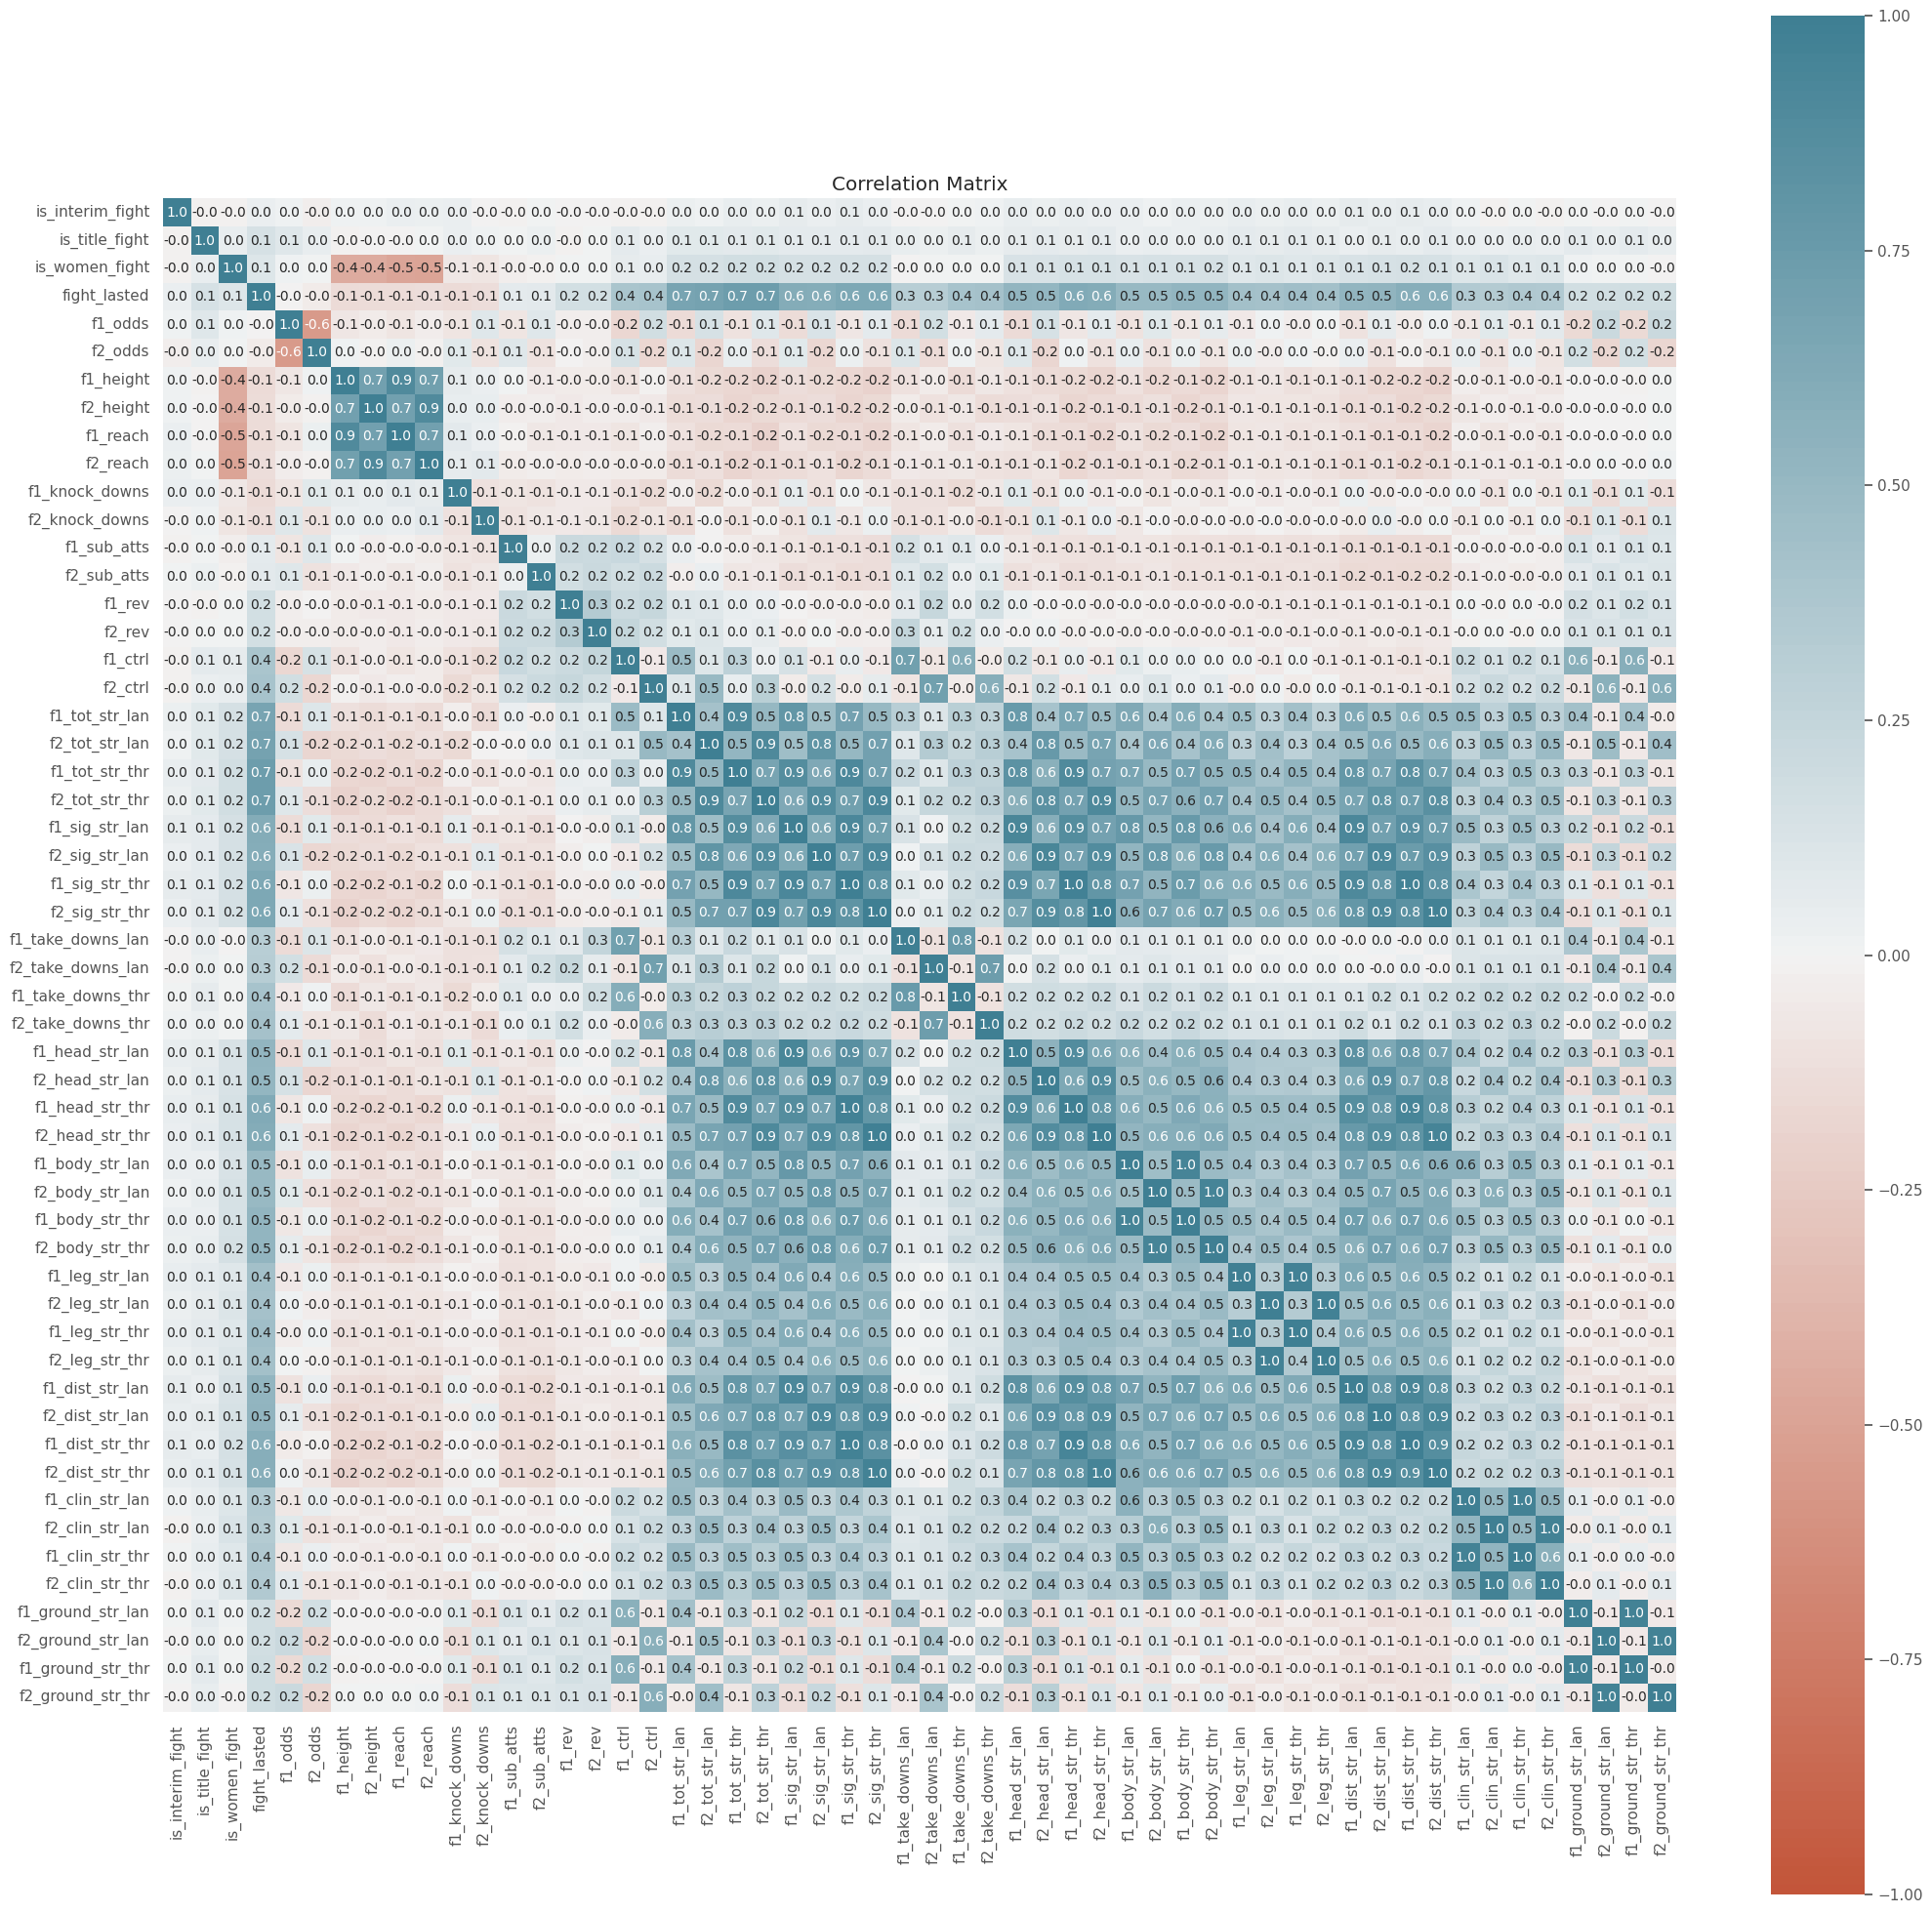

In [691]:
numerical_columns = df.select_dtypes(include=np.number).columns[1:].tolist()

plt.figure(figsize=(25, 25))
plt.title("Correlation Matrix")
sns.heatmap(
    df[numerical_columns].corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    fmt=".1f",
    annot=True
)

plt.show()

### <div style="margin-left: 1em;">Correlated Features</div>
<div style="margin-left: 3em;"><font color='gray'>
   <strong><font color='#A9A9A9'>Positive</font></strong> 
      <li><u><font color='grey'>Height to Reach</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the wider hir arm reach will be</font></div>
      <li><u><font color='grey'>Fight lasted in seconds to strikes landed/thrown</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The longer a fight drags on the more strikes will be thrown</font></div>
      <li><u><font color='grey'>Total strikes to significant strikes</u></li>
         <div style="margin-left: 2em;"><font color='gray'>Significant strikes is just a portion of total ones</font></div><br>
   <strong><font color='#A9A9A9'>Negative</font></strong> 
      <li><u><font color='grey'>Height/Reach to whether it's a women/men fight</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the lesser probability is that its a fight between women</font></div>
      <li><u><font color='grey'>Odds of the fighters</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The higher winning odds of a fighter the lesser ones of the other one</font></div>

These correlations wont matter for a boosting models such as Catboost</font></div>

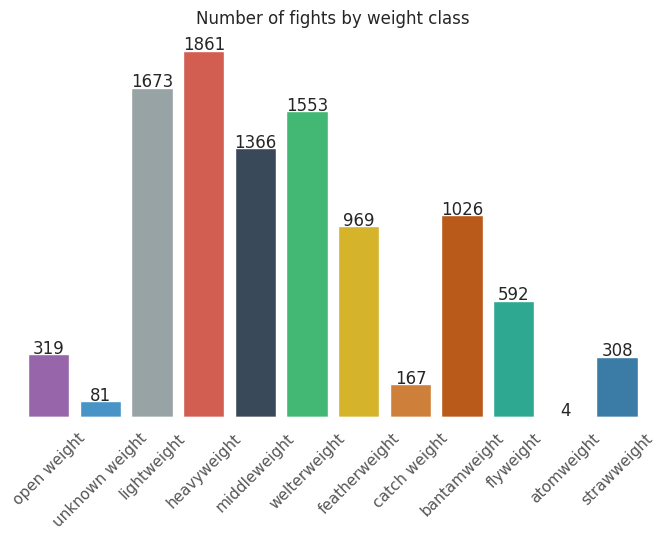

In [692]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.set_theme(style="white")
palette = [
    "#9b59b6", 
    "#3498db", 
    "#95a5a6", 
    "#e74c3c", 
    "#34495e", 
    "#2ecc71", 
    "#f1c40f", 
    "#e67e22", 
    "#d35400", 
    "#1abc9c", 
    "#27ae60", 
    "#2980b9"
]
ax = sns.countplot(
    x='weight_class', 
    hue='weight_class', 
    data=events_df, 
    palette=palette, 
    legend=False
)
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x()+p.get_width()/2., 
            height + 3,
            height, 
            ha="center")
ax.set_title("Number of fights by weight class")
ax.set_ylabel("")  
ax.set_xlabel("")
ax.grid(False)
plt.gca().set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
ax.set_yticks([])
plt.show()


<Figure size 800x500 with 0 Axes>

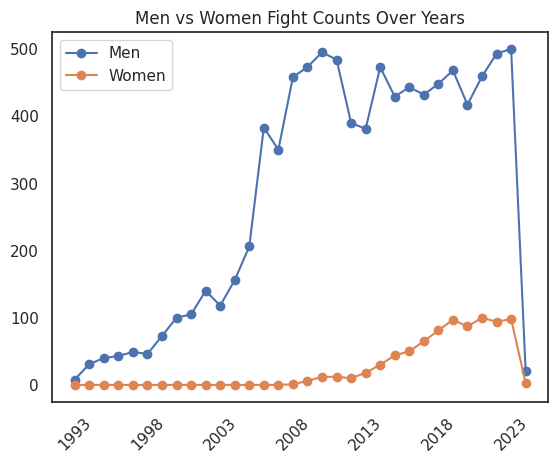

In [693]:
plt.figure(figsize=(8,5))
fight_counts = (
    df.groupby([df['event_date'].dt.year, 'is_women_fight'])
        .size()
        .unstack(fill_value=0)
)
sns.set_style("white")
fight_counts.plot(kind='line', marker='o')
plt.title('Men vs Women Fight Counts Over Years')
plt.legend(['Men', 'Women'])
plt.xticks(fight_counts.index[::5])
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

<div style="margin-left: 1em;"><font color='gray'>The women divition was introduced not that long ago hence the disproportion. The lines suddenly drop as we have data up to February 2024</font></div>

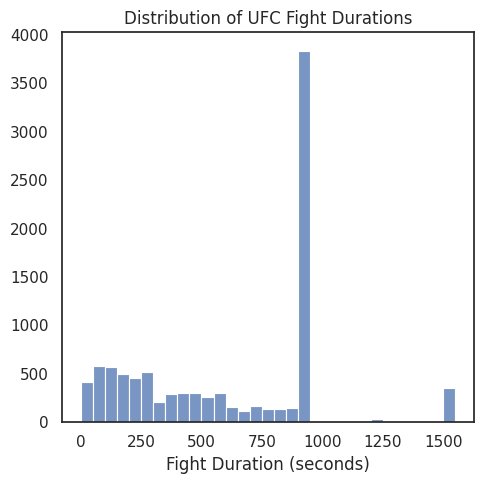

In [694]:
plt.figure(figsize=(5,5))
sns.histplot(data=events_df, x='fight_lasted', bins=np.arange(0, 1600, 50))
sns.set_style("white")

plt.xlabel('Fight Duration (seconds)')  
plt.ylabel('')
plt.title('Distribution of UFC Fight Durations')

plt.tight_layout()
plt.show()


<div style="margin-left: 1em;"><font color='gray'>As we can see most of the fights last all 5 rounds with some fights lasted around 1500 seconds. These are the old "Unlimited" fights. From the graph we can see that if probability of a fight to end in early rounds is higher and as the fights go on the probability decreases. It might have something to do with stamina depletion. </font></div>

In [695]:
event_country_counts = df['event_country'].value_counts()

fig = px.pie(
    names=event_country_counts.index,
    values=event_country_counts.values,
    title='UFC Events by Country',
    hole=0.5,
    width=700,
    height=500   
)

fig.update_traces(textposition='inside', textinfo='label')
fig.show()

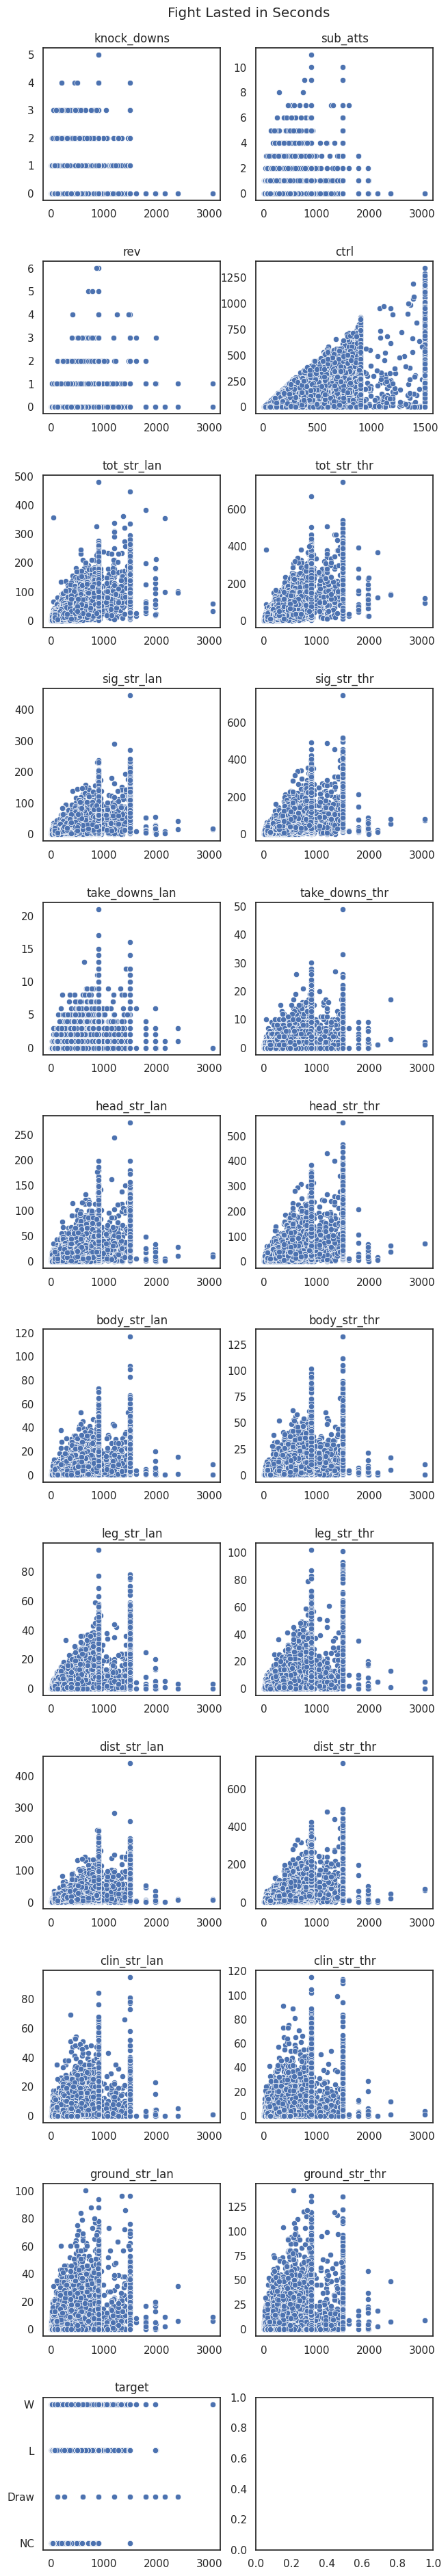

In [696]:
columns = fighters_df.loc[:,"knock_downs":].columns.to_list()

nrows=math.ceil(len(columns)/2)

fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(6, 40))
fig.suptitle("Fight Lasted in Seconds")
plt.subplots_adjust(
    left=0, 
    right=0.95, 
    top=0.965, 
    bottom=0.05, 
    wspace=0.2, 
    hspace=0.4
)

for i, ax in enumerate(axes.flat):
    if i >= len(columns):
        break
    col = columns[i]
    sns.scatterplot(
        x='fight_lasted', 
        y=col, 
        data=fighters_df, 
        ax=ax
    )
    ax.set_title(col)
    ax.set(ylabel='')
    ax.set(xlabel='')

plt.show()

## 5. Feature Selection and Creation


In [697]:
# Creating age feature
fighters_df['age_at_event'] = (
    (fighters_df['event_date'] - fighters_df['dob']).dt.days / 365
)

# Creating wins, losses, draws, ncs and winning streaks
def get_stats(fighters_df):
    features = {
        'winning_streak': [],
        'wins_over_carrier': [],
        'losses_over_carrier': [],
        'draws_over_carrier': [],
        'ncs_over_carrier': []
    }
    for fighters_index, fighters_row in fighters_df.iterrows():
        mask = (fighters_df['name'] == fighters_row['name'])
        slice = fighters_df.loc[
            mask & (fighters_df.index <= fighters_index), 
            ['target']
        ]
        win_streak = 0
        wins = len(fighters_df[mask & (fighters_df['target'] == 'W')])
        losses = len(fighters_df[mask & (fighters_df['target'] == 'L')])
        draws = len(fighters_df[mask & (fighters_df['target'] == 'Draw')])
        ncs = len(fighters_df[mask & (fighters_df['target'] == 'NC')])

        for _, slice_row in slice[::-1].iterrows():
            if slice_row['target'] == 'W':
                win_streak += 1
            elif slice_row['target'] == 'Draw':
                win_streak += 0
            elif slice_row['target'] == 'NC':
                win_streak += 0
            else:
                break

        features['winning_streak'].append(win_streak)  
        features['wins_over_carrier'].append(wins)  
        features['losses_over_carrier'].append(losses)  
        features['draws_over_carrier'].append(draws)  
        features['ncs_over_carrier'].append(ncs)  
    return pd.DataFrame(features)

features_df = get_stats(fighters_df)
fighters_df = pd.concat([fighters_df, features_df], axis=1)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier
0,0,1993-11-12,59.0,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,1.0,0.0,0.0,NaN,11.0,17.0,11.0,17.0,0.0,0.0,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W,34.646575,1,3,0,0,0
1,0,1993-11-12,59.0,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,0.0,0.0,0.0,NaN,0.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,W,NaN,1,1,2,0,0
2,1,1993-11-12,52.0,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,9.0,3.0,9.0,1.0,2.0,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,L,24.320548,0,2,2,0,0
3,1,1993-11-12,52.0,Trent Jenkins,NaT,NaN,74.0,Other,NaN,0.0,0.0,0.0,NaN,1.0,7.0,1.0,7.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L,NaN,0,1,1,0,0
4,2,1993-11-12,104.0,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W,26.936986,1,7,8,2,0


In [698]:
# Creating days_till_next_fight feature
def get_days_till_next_fight(fighters_df):
    feature = list()
    for fighters_index, fighters_row in fighters_df.iterrows():
        mask = (fighters_df['name'] == fighters_row['name'])
        slice = fighters_df.loc[
            mask & (fighters_df.index > fighters_index), 
            ['event_date']
        ]
        if not slice.empty:
            next_date = slice.iloc[0]['event_date'] 
            days_till_next_fight = (next_date - fighters_row['event_date']).days
            feature.append(days_till_next_fight)
        else:
            feature.append(None)
    return pd.Series(feature)

fighters_df['days_till_next_fight'] = get_days_till_next_fight(fighters_df)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_till_next_fight
0,0,1993-11-12,59.0,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,1.0,0.0,0.0,NaN,11.0,17.0,11.0,17.0,0.0,0.0,7.0,13.0,1.0,1.0,3.0,3.0,5.0,8.0,0.0,0.0,6.0,9.0,W,34.646575,1,3,0,0,0,0.0
1,0,1993-11-12,59.0,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,0.0,0.0,0.0,NaN,0.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,W,NaN,1,1,2,0,0,0.0
2,1,1993-11-12,52.0,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,9.0,3.0,9.0,1.0,2.0,3.0,7.0,0.0,1.0,0.0,1.0,3.0,9.0,0.0,0.0,0.0,0.0,L,24.320548,0,2,2,0,0,119.0
3,1,1993-11-12,52.0,Trent Jenkins,NaT,NaN,74.0,Other,NaN,0.0,0.0,0.0,NaN,1.0,7.0,1.0,7.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,L,NaN,0,1,1,0,0,764.0
4,2,1993-11-12,104.0,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3.0,4.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,W,26.936986,1,7,8,2,0,0.0


In [699]:
# Creating annual cumulative rolling features
def get_rolling_features(df, cols, weeks, stat):
    rolling_features = [
        f"{col}_{stat}_over_{int(weeks/52)}_year" for col in cols
    ] 
    rolling_features_df = pd.DataFrame(columns=rolling_features)

    for index, row in df.iterrows():
        time_constraint = row['event_date'] - pd.Timedelta(weeks=weeks)
        mask = (
            (df['name'] == row['name']) &
            (df['event_date'] >= time_constraint)
        )
        slice_df = df.loc[
            mask & (df.index <= index), 
            ['event_date', 'name'] + cols
        ]
        for col in cols:
            if stat == "mean":
                result = slice_df[col].mean()
            elif stat == "sum":
                result = slice_df[col].sum()
            elif stat == "count":
                result = slice_df[col].count()
            else:
                result = None
            col_name = f"{col}_{stat}_over_{int(weeks/52)}_year"
            rolling_features_df.loc[index,col_name] = result
 
    return rolling_features_df


year_in_weeks = 52

# Creating rolling mean features
rolling_mean_cols = ( ['fight_lasted'] +
    fighters_df.loc[:, 'knock_downs':'ground_str_thr'].columns.tolist() 
)
rolling_mean_df = get_rolling_features(
    fighters_df, 
    rolling_mean_cols, 
    year_in_weeks, 
    'mean'
)
fighters_df = pd.concat([fighters_df, rolling_mean_df], axis=1)

# Creating rolling count features
rolling_count_cols = ['target']
rolling_count_df = get_rolling_features(
    fighters_df, 
    rolling_count_cols, 
    year_in_weeks, 
    'count'
)
fighters_df = pd.concat([fighters_df, rolling_count_df], axis=1)


fighters_df.rename(columns={
    'target_count_over_1_year':'num_of_fights_over_1_year'
    }, inplace=True)
fighters_df.drop(columns='target', inplace=True)
fighters_df = fighters_df.reindex(columns=NEW_ORDER_3)
fighters_df.head()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event,days_till_next_fight,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,num_of_fights_over_1_year,fight_lasted,fight_lasted_mean_over_1_year,knock_downs,knock_downs_mean_over_1_year,sig_str_lan,sig_str_lan_mean_over_1_year,sig_str_thr,sig_str_thr_mean_over_1_year,tot_str_lan,tot_str_lan_mean_over_1_year,tot_str_thr,tot_str_thr_mean_over_1_year,take_downs_lan,take_downs_lan_mean_over_1_year,take_downs_thr,take_downs_thr_mean_over_1_year,sub_atts,sub_atts_mean_over_1_year,rev,rev_mean_over_1_year,ctrl,ctrl_mean_over_1_year,head_str_lan,head_str_lan_mean_over_1_year,head_str_thr,head_str_thr_mean_over_1_year,body_str_lan,body_str_lan_mean_over_1_year,body_str_thr,body_str_thr_mean_over_1_year,leg_str_lan,leg_str_lan_mean_over_1_year,leg_str_thr,leg_str_thr_mean_over_1_year,dist_str_lan,dist_str_lan_mean_over_1_year,dist_str_thr,dist_str_thr_mean_over_1_year,clin_str_lan,clin_str_lan_mean_over_1_year,clin_str_thr,clin_str_thr_mean_over_1_year,ground_str_lan,ground_str_lan_mean_over_1_year,ground_str_thr,ground_str_thr_mean_over_1_year
0,0,1993-11-12,Gerard Gordeau,1959-03-30,NaN,77.0,Orthodox,NaN,34.646575,0.0,3,0,0,0,1,59.0,59.0,1.0,1.0,11.0,11.0,17.0,17.0,11.0,11.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,7.0,7.0,13.0,13.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,5.0,5.0,8.0,8.0,0.0,0.0,0.0,0.0,6.0,6.0,9.0,9.0
1,0,1993-11-12,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,NaN,0.0,1,2,0,0,1,59.0,59.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1993-11-12,Jason DeLucia,1969-07-24,NaN,71.0,Southpaw,NaN,24.320548,119.0,2,2,0,0,1,52.0,52.0,0.0,0.0,3.0,3.0,9.0,9.0,3.0,3.0,9.0,9.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,NaN,NaN,3.0,3.0,7.0,7.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1993-11-12,Trent Jenkins,NaT,NaN,74.0,Other,NaN,NaN,764.0,1,1,0,0,1,52.0,52.0,0.0,0.0,1.0,1.0,7.0,7.0,1.0,1.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,5.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1993-11-12,Royce Gracie,1966-12-12,NaN,73.0,Southpaw,NaN,26.936986,0.0,7,8,2,0,1,104.0,104.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,1.0,1.0,3.0,3.0,1.0,1.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [700]:
# Shifting values to prevent data leakage
cols = fighters_df.loc[:, 'age_at_event':].columns.tolist() 

for col in cols:
    fighters_df[f"{col}_shift_1"] = (
        fighters_df.groupby(['name'])[f"{col}"].shift(1)
    )
fighters_df.drop(columns=cols, inplace=True)
fighters_df.tail()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event_shift_1,days_till_next_fight_shift_1,wins_over_carrier_shift_1,losses_over_carrier_shift_1,draws_over_carrier_shift_1,ncs_over_carrier_shift_1,num_of_fights_over_1_year_shift_1,fight_lasted_shift_1,fight_lasted_mean_over_1_year_shift_1,knock_downs_shift_1,knock_downs_mean_over_1_year_shift_1,sig_str_lan_shift_1,sig_str_lan_mean_over_1_year_shift_1,sig_str_thr_shift_1,sig_str_thr_mean_over_1_year_shift_1,tot_str_lan_shift_1,tot_str_lan_mean_over_1_year_shift_1,tot_str_thr_shift_1,tot_str_thr_mean_over_1_year_shift_1,take_downs_lan_shift_1,take_downs_lan_mean_over_1_year_shift_1,take_downs_thr_shift_1,take_downs_thr_mean_over_1_year_shift_1,sub_atts_shift_1,sub_atts_mean_over_1_year_shift_1,rev_shift_1,rev_mean_over_1_year_shift_1,ctrl_shift_1,ctrl_mean_over_1_year_shift_1,head_str_lan_shift_1,head_str_lan_mean_over_1_year_shift_1,head_str_thr_shift_1,head_str_thr_mean_over_1_year_shift_1,body_str_lan_shift_1,body_str_lan_mean_over_1_year_shift_1,body_str_thr_shift_1,body_str_thr_mean_over_1_year_shift_1,leg_str_lan_shift_1,leg_str_lan_mean_over_1_year_shift_1,leg_str_thr_shift_1,leg_str_thr_mean_over_1_year_shift_1,dist_str_lan_shift_1,dist_str_lan_mean_over_1_year_shift_1,dist_str_thr_shift_1,dist_str_thr_mean_over_1_year_shift_1,clin_str_lan_shift_1,clin_str_lan_mean_over_1_year_shift_1,clin_str_thr_shift_1,clin_str_thr_mean_over_1_year_shift_1,ground_str_lan_shift_1,ground_str_lan_mean_over_1_year_shift_1,ground_str_thr_shift_1,ground_str_thr_mean_over_1_year_shift_1
19833,9916,2024-01-20,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68.0,34.567123,126.0,4.0,3.0,0.0,0.0,3,900.0,900.0,0.0,0.0,77.0,56.0,206.0,139.333333,95.0,119.666667,225.0,225.0,2.0,2.333333,10.0,6.333333,0.0,0.0,0.0,0.0,180.0,442.0,43.0,37.333333,148.0,111.333333,25.0,14.333333,47.0,23.0,9.0,4.333333,11.0,5.0,58.0,42.333333,176.0,118.0,19.0,11.0,30.0,16.333333,0.0,2.666667,0.0,5.0
19834,9917,2024-01-20,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72.0,29.249315,259.0,5.0,3.0,0.0,0.0,2,900.0,900.0,0.0,0.0,88.0,78.0,129.0,129.0,183.0,163.5,228.0,220.5,4.0,6.5,7.0,11.5,0.0,0.0,0.0,0.0,510.0,458.5,76.0,63.0,116.0,112.5,3.0,7.5,3.0,8.5,9.0,7.5,10.0,8.0,45.0,48.0,81.0,95.5,11.0,6.5,11.0,6.5,32.0,23.5,37.0,27.0
19835,9917,2024-01-20,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70.0,29.246575,280.0,8.0,4.0,0.0,0.0,2,1500.0,904.0,0.0,0.0,76.0,52.0,225.0,146.0,80.0,54.0,229.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,32.5,48.0,34.5,173.0,114.0,18.0,10.0,36.0,20.5,10.0,7.5,16.0,11.5,76.0,51.5,225.0,143.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.5
19836,9918,2024-01-20,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70.0,29.769863,102.0,2.0,1.0,0.0,0.0,2,29.0,87.5,1.0,0.5,10.0,10.5,17.0,18.0,10.0,10.5,17.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.5,13.0,15.5,3.0,1.5,4.0,2.0,0.0,0.5,0.0,0.5,8.0,9.5,15.0,17.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0
19837,9918,2024-01-20,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72.0,27.189041,137.0,1.0,1.0,0.0,0.0,1,146.0,146.0,1.0,1.0,11.0,11.0,31.0,31.0,11.0,11.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,7.0,24.0,24.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,1.0,10.0,10.0,26.0,26.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0


In [701]:
fighters_df.to_parquet('./processed_data/fighters_df.parquet')

## 6. Model Training

In [2]:
df = pd.read_parquet('./processed_data/df.parquet')
events_df = pd.read_parquet('./processed_data/events_df.parquet')
fighters_df = pd.read_parquet('./processed_data/fighters_df.parquet')

In [3]:
# Remerging dataframes for model training
def renaming_dict(x):
    return { 
        col: f"f{x}_{col}" if col not in ['fight_id', 'event_date'] else col 
        for col in fighters_df.columns.tolist()
    }

def merging_cols(x):
    return ['fight_id', 'event_date', f'f{x}_name']

baseline_df = events_df

for num in [1,2]:
    baseline_df = pd.merge(
        baseline_df, 
        fighters_df.rename(renaming_dict(num), axis=1),
        how='left',
        left_on=merging_cols(num), 
        right_on=merging_cols(num)
    )

# Rearranging column ordering
f1_cols = baseline_df.columns[13:71]
f2_cols = baseline_df.columns[71:]
merged_cols = [col for pair in zip(f1_cols, f2_cols) for col in pair]
columns = baseline_df.columns[:13].to_list() + merged_cols
baseline_df = baseline_df.reindex(columns=columns)

baseline_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,target,f1_name,f2_name,f1_ground_str_thr_mean_over_1_year_shift_1,f1_dob,f2_dob,f1_odds,f2_odds,f1_height,f2_height,f1_stance,f2_stance,f1_reach,f2_reach,f1_age_at_event_shift_1,f2_age_at_event_shift_1,f1_days_till_next_fight_shift_1,f2_days_till_next_fight_shift_1,f1_wins_over_carrier_shift_1,f2_wins_over_carrier_shift_1,f1_losses_over_carrier_shift_1,f2_losses_over_carrier_shift_1,f1_draws_over_carrier_shift_1,f2_draws_over_carrier_shift_1,f1_ncs_over_carrier_shift_1,f2_ncs_over_carrier_shift_1,f1_num_of_fights_over_1_year_shift_1,f2_num_of_fights_over_1_year_shift_1,f1_fight_lasted_shift_1,f2_fight_lasted_shift_1,f1_fight_lasted_mean_over_1_year_shift_1,f2_fight_lasted_mean_over_1_year_shift_1,f1_knock_downs_shift_1,f2_knock_downs_shift_1,f1_knock_downs_mean_over_1_year_shift_1,f2_knock_downs_mean_over_1_year_shift_1,f1_sig_str_lan_shift_1,f2_sig_str_lan_shift_1,f1_sig_str_lan_mean_over_1_year_shift_1,f2_sig_str_lan_mean_over_1_year_shift_1,f1_sig_str_thr_shift_1,f2_sig_str_thr_shift_1,f1_sig_str_thr_mean_over_1_year_shift_1,f2_sig_str_thr_mean_over_1_year_shift_1,f1_tot_str_lan_shift_1,f2_tot_str_lan_shift_1,f1_tot_str_lan_mean_over_1_year_shift_1,f2_tot_str_lan_mean_over_1_year_shift_1,f1_tot_str_thr_shift_1,f2_tot_str_thr_shift_1,f1_tot_str_thr_mean_over_1_year_shift_1,f2_tot_str_thr_mean_over_1_year_shift_1,f1_take_downs_lan_shift_1,f2_take_downs_lan_shift_1,f1_take_downs_lan_mean_over_1_year_shift_1,f2_take_downs_lan_mean_over_1_year_shift_1,f1_take_downs_thr_shift_1,f2_take_downs_thr_shift_1,f1_take_downs_thr_mean_over_1_year_shift_1,f2_take_downs_thr_mean_over_1_year_shift_1,f1_sub_atts_shift_1,f2_sub_atts_shift_1,f1_sub_atts_mean_over_1_year_shift_1,f2_sub_atts_mean_over_1_year_shift_1,f1_rev_shift_1,f2_rev_shift_1,f1_rev_mean_over_1_year_shift_1,f2_rev_mean_over_1_year_shift_1,f1_ctrl_shift_1,f2_ctrl_shift_1,f1_ctrl_mean_over_1_year_shift_1,f2_ctrl_mean_over_1_year_shift_1,f1_head_str_lan_shift_1,f2_head_str_lan_shift_1,f1_head_str_lan_mean_over_1_year_shift_1,f2_head_str_lan_mean_over_1_year_shift_1,f1_head_str_thr_shift_1,f2_head_str_thr_shift_1,f1_head_str_thr_mean_over_1_year_shift_1,f2_head_str_thr_mean_over_1_year_shift_1,f1_body_str_lan_shift_1,f2_body_str_lan_shift_1,f1_body_str_lan_mean_over_1_year_shift_1,f2_body_str_lan_mean_over_1_year_shift_1,f1_body_str_thr_shift_1,f2_body_str_thr_shift_1,f1_body_str_thr_mean_over_1_year_shift_1,f2_body_str_thr_mean_over_1_year_shift_1,f1_leg_str_lan_shift_1,f2_leg_str_lan_shift_1,f1_leg_str_lan_mean_over_1_year_shift_1,f2_leg_str_lan_mean_over_1_year_shift_1,f1_leg_str_thr_shift_1,f2_leg_str_thr_shift_1,f1_leg_str_thr_mean_over_1_year_shift_1,f2_leg_str_thr_mean_over_1_year_shift_1,f1_dist_str_lan_shift_1,f2_dist_str_lan_shift_1,f1_dist_str_lan_mean_over_1_year_shift_1,f2_dist_str_lan_mean_over_1_year_shift_1,f1_dist_str_thr_shift_1,f2_dist_str_thr_shift_1,f1_dist_str_thr_mean_over_1_year_shift_1,f2_dist_str_thr_mean_over_1_year_shift_1,f1_clin_str_lan_shift_1,f2_clin_str_lan_shift_1,f1_clin_str_lan_mean_over_1_year_shift_1,f2_clin_str_lan_mean_over_1_year_shift_1,f1_clin_str_thr_shift_1,f2_clin_str_thr_shift_1,f1_clin_str_thr_mean_over_1_year_shift_1,f2_clin_str_thr_mean_over_1_year_shift_1,f1_ground_str_lan_shift_1,f2_ground_str_lan_shift_1,f1_ground_str_lan_mean_over_1_year_shift_1,f2_ground_str_lan_mean_over_1_year_shift_1,f1_ground_str_thr_shift_1,f2_ground_str_thr_shift_1
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,F1,Gerard Gordeau,Kevin Rosier,NaN,1959-03-30,NaT,NaN,NaN,77.0,76.0,Orthodox,Orthodox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [4]:
split_date = baseline_df['event_date'].max() - pd.Timedelta(days=120)
split_date

Timestamp('2023-09-22 00:00:00')

In [7]:
np.random.seed(42)

pd.DataFrame.iteritems = pd.DataFrame.items


df_train = baseline_df[baseline_df['event_date'] <= split_date]
df_test = baseline_df[baseline_df['event_date'] > split_date]

drop_features = (
    ['fight_id', 'fight_lasted','event_date', 'method',
    'referee', 'details', 'f1_name', 'f2_name', 'target', 'f1_dob', 'f2_dob'] 
)

features = list(
    set(baseline_df.columns) - 
    set(drop_features) 
) 

cat_features = ['event_country', 'weight_class', 'f1_stance', 'f2_stance']

CBC = CatBoostClassifier(
    n_estimators=2000, 
    loss_function='MultiClass', 
    od_type = "Iter",
    od_wait = 50)

CBC.fit(
    df_train[features], 
    df_train['target'], 
    eval_set=(
        df_test[features], 
        df_test['target']), 
    verbose=200,
    cat_features=cat_features
)

preds = CBC.predict(df_test[features])

Learning rate set to 0.086722
0:	learn: 1.2817836	test: 1.3109729	best: 1.3109729 (0)	total: 28.3ms	remaining: 56.6s
200:	learn: 0.4678755	test: 0.7006556	best: 0.6986462 (196)	total: 5.67s	remaining: 50.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6986462488
bestIteration = 196

Shrink model to first 197 iterations.


In [8]:
precision = precision_score(
    df_test['target'], preds, average='micro'
)
precision

0.5870967741935483

In [9]:
print(classification_report(df_test['target'], preds))

              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00         2
          F1       0.59      0.67      0.62        75
          F2       0.59      0.55      0.57        74
          NC       0.00      0.00      0.00         4

    accuracy                           0.59       155
   macro avg       0.30      0.31      0.30       155
weighted avg       0.57      0.59      0.58       155



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [707]:
pd.DataFrame(
    np.vstack([CBC.feature_names_, CBC.feature_importances_]).T, 
    columns = ['features', 'score']
    )\
        .astype({'score': float})\
        .sort_values('score', ascending=False)\
        .head(20)

,features,score
40,f1_wins_over_carrier_shift_1,11.657900
84,f2_losses_over_carrier_shift_1,11.107402
112,f1_ncs_over_carrier_shift_1,9.808509
64,f1_draws_over_carrier_shift_1,8.349883
93,f2_ncs_over_carrier_shift_1,6.474835
23,f2_draws_over_carrier_shift_1,4.359644
97,f1_reach,3.572500
113,f2_reach,3.441768
7,f2_age_at_event_shift_1,3.040490
83,f2_wins_over_carrier_shift_1,2.371950


In [721]:
def objective(trial):

    params = {
        "learning_rate": 
            trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "objective": 
            trial.suggest_categorical(
                "objective", ["MultiClass", "MultiClassOneVsAll"]
                ),
        "colsample_bylevel": 
            trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": 
            trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": 
            trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "boosting_type": 
            trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": 
            trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = (
            trial.suggest_float("bagging_temperature", 0, 10)
        )
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = (
            trial.suggest_float("subsample", 0.1, 1, log=True)
        )
        
    tscv = TimeSeriesSplit(n_splits=5)  

    precision_scores = []

    for train_index, val_index in tscv.split(df_train):
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        CBC = CatBoostClassifier(
            **params,
            n_estimators=2000,
            loss_function='MultiClass',
            od_type = "Iter",
            od_wait = 50,
            verbose=False
        )
        CBC.fit(
            train_data[features], 
            train_data['target'], 
            cat_features=cat_features
        )
        y_pred = CBC.predict(val_data[features])
        precision = precision_score(val_data['target'], y_pred, average='micro')
        precision_scores.append(precision)

    return np.mean(precision_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)

study = optuna.create_study(direction="maximize", sampler=sampler)

In [722]:
study.optimize(objective, n_trials=100)

In [723]:
study_df = study.trials_dataframe()
study_df.to_parquet("./CBC_study.parquet")
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

In [724]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 0.010053497090322536, 'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07712510767048934, 'depth': 6, 'l2_leaf_reg': 3.3463604556400405e-05, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.268257313038454}


In [737]:
optuna.visualization.plot_optimization_history(study)

In [739]:
optuna.visualization.plot_slice(
    study, 
    params=[
        "learning_rate",
        "objective",
        "colsample_bylevel",
        "depth",
        "l2_leaf_reg",
        "boosting_type",
        "bootstrap_type",
        "bagging_temperature",
        "subsample"
    ]
)

In [740]:
optuna.visualization.plot_param_importances(study)

In [741]:
# Best hyperparameters: {
#     'learning_rate': 0.010053497090322536, 
#     'objective': 'MultiClassOneVsAll', 
#     'colsample_bylevel': 0.07712510767048934, 
#     'depth': 6, 
#     'l2_leaf_reg': 3.3463604556400405e-05, 
#     'boosting_type': 'Plain', 
#     'bootstrap_type': 'Bayesian', 
#     'bagging_temperature': 0.268257313038454
# }

# Best hyperparameters: {
# 'learning_rate': 0.03553264865886361, 
# 'depth': 10, 
# 'l2_leaf_reg': 5.108185184887566e-07, 
# 'bootstrap_type': 'Bayesian', 
# 'random_strength': 0.0011510240798173687, 
# 'bagging_temperature': 0.03376291809001275
# }

with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)
    
CBC = CatBoostClassifier(
    **best_params,
    n_estimators=2000,
    loss_function='MultiClass', 
    od_type = "Iter",
    od_wait = 50
)
CBC.fit(df_train[features], 
        df_train['target'],
        eval_set=(df_test[features], df_test['target']),
        verbose=100,
        cat_features=cat_features)

preds = CBC.predict(df_test[features])
probs = CBC.predict_proba(df_test[features])

0:	learn: 0.6882689	test: 0.6884323	best: 0.6884323 (0)	total: 4.75ms	remaining: 9.5s


100:	learn: 0.4261353	test: 0.4552976	best: 0.4552976 (100)	total: 637ms	remaining: 12s
200:	learn: 0.3448027	test: 0.3947998	best: 0.3947998 (200)	total: 1.29s	remaining: 11.6s
300:	learn: 0.3115386	test: 0.3764013	best: 0.3764013 (300)	total: 1.89s	remaining: 10.7s
400:	learn: 0.2953839	test: 0.3669368	best: 0.3669368 (400)	total: 2.5s	remaining: 9.98s
500:	learn: 0.2842291	test: 0.3591985	best: 0.3591298 (498)	total: 3.12s	remaining: 9.34s
600:	learn: 0.2754971	test: 0.3532499	best: 0.3532499 (600)	total: 3.74s	remaining: 8.71s
700:	learn: 0.2695183	test: 0.3502033	best: 0.3500790 (695)	total: 4.36s	remaining: 8.09s
800:	learn: 0.2632516	test: 0.3457569	best: 0.3457569 (800)	total: 4.97s	remaining: 7.45s
900:	learn: 0.2576233	test: 0.3429610	best: 0.3429610 (900)	total: 5.6s	remaining: 6.83s
1000:	learn: 0.2526492	test: 0.3409861	best: 0.3409098 (998)	total: 6.22s	remaining: 6.21s
1100:	learn: 0.2471099	test: 0.3392324	best: 0.3391328 (1092)	total: 6.85s	remaining: 5.59s
1200:	learn

In [742]:
precision = precision_score(
    df_test['target'], CBC.predict(df_test[features]), average ='micro'
)
precision

# Precision (average='micro')
# Baseline - 0.5172413793103449
# Initial oputna search - 0.7548387096774194
# Secondary oputna search - 0.7612903225806451

0.6129032258064516

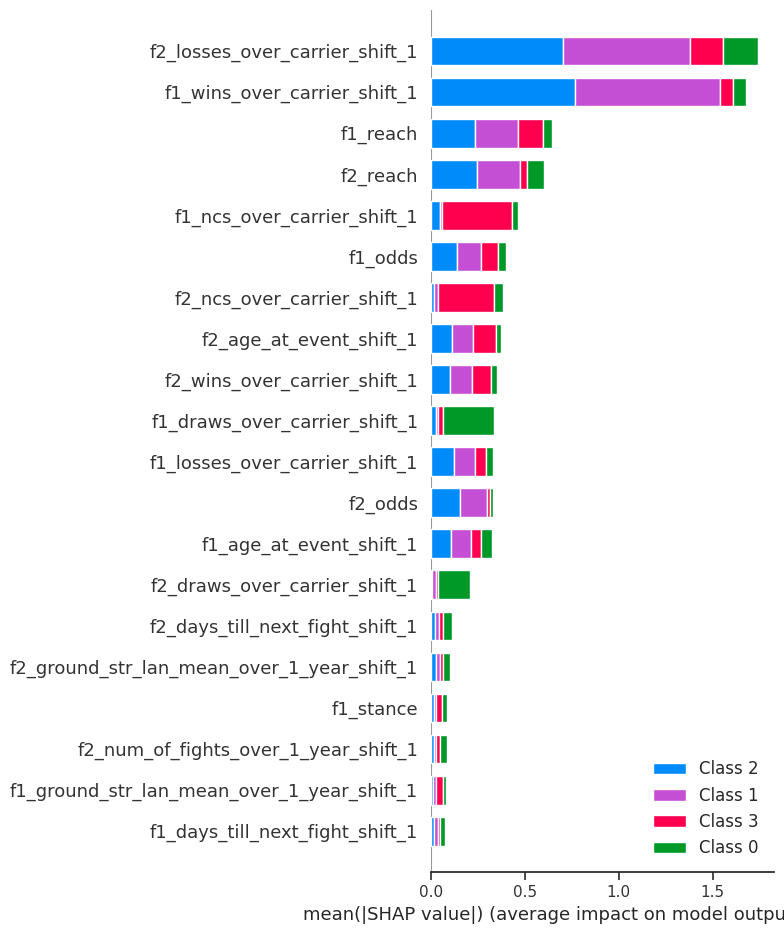

In [749]:
shap_values = shap.Explainer(CBC).shap_values(df_train[features])
shap.summary_plot(
    shap_values, 
    df_train[features],
    plot_type="bar",  
    max_display=20
)

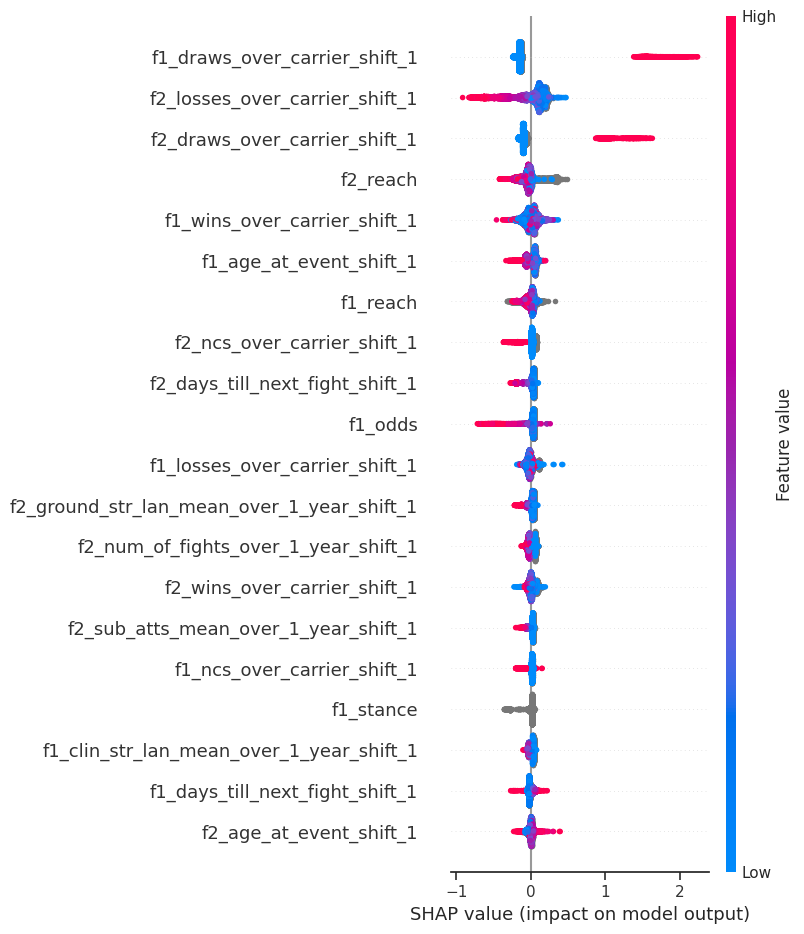

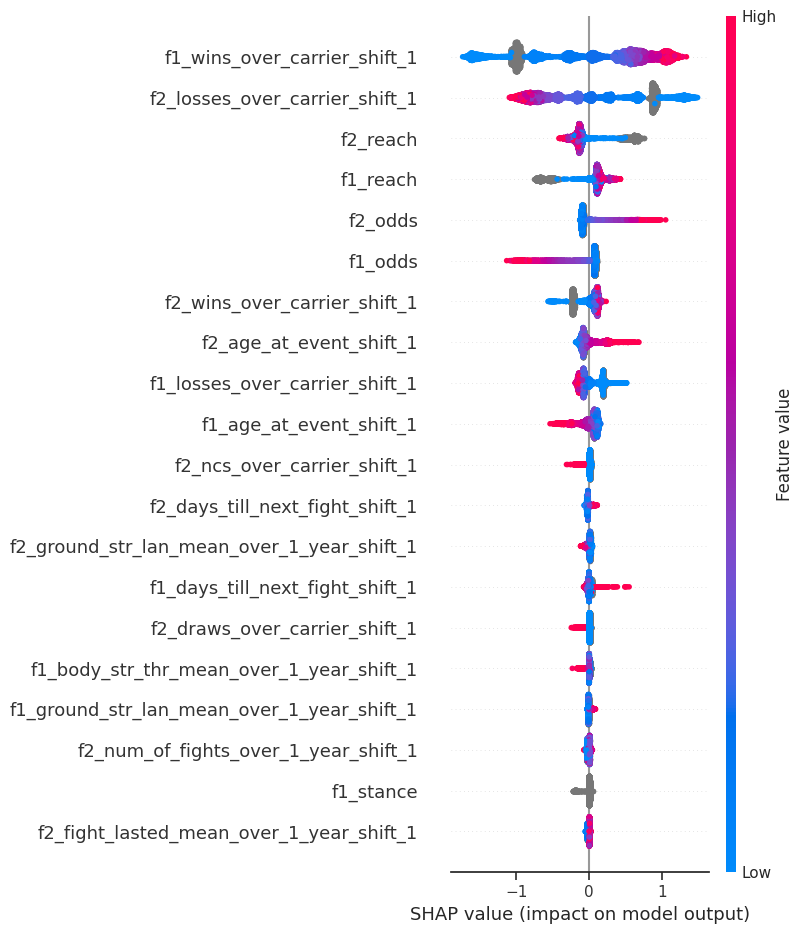

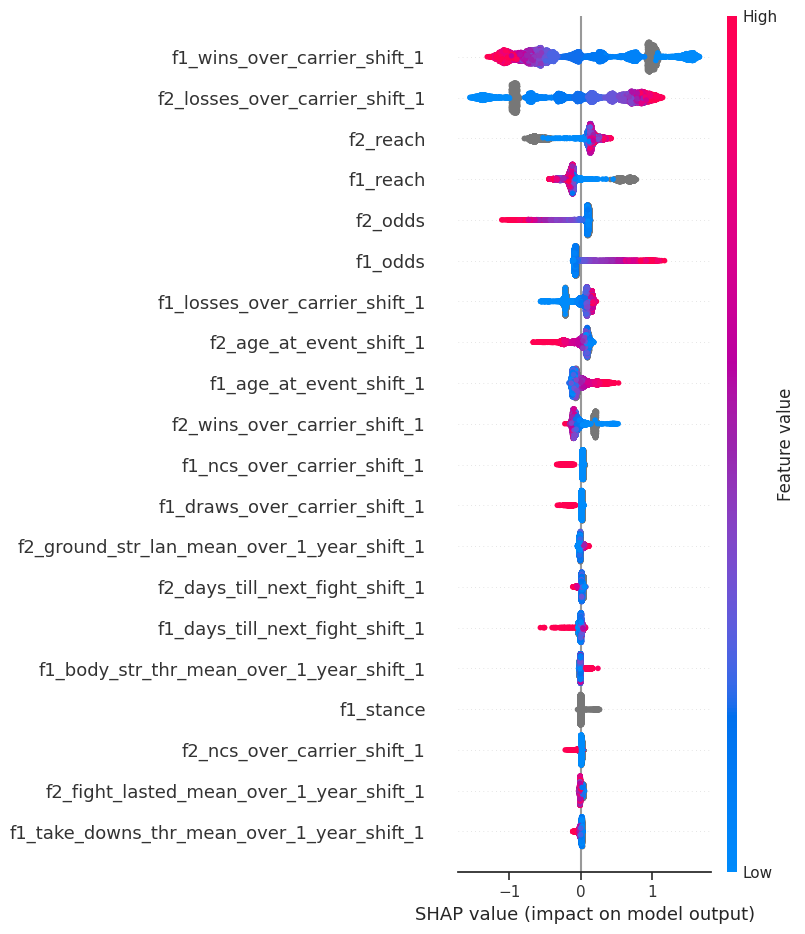

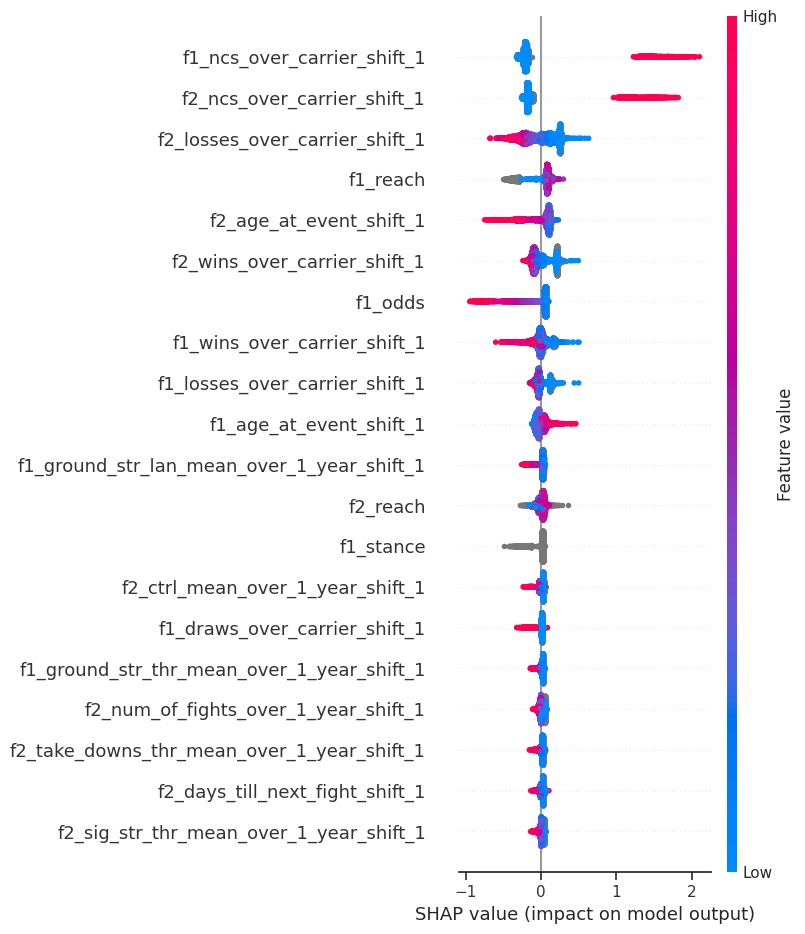

In [750]:
for i in range(4): 
    shap.summary_plot(
        shap_values[i],
        df_train[features],
        plot_type="dot"
    )

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

all_importances = []

for train_index, val_index in tscv.split(df_train[features]):
   X_train, X_val = (
      df_train.loc[train_index, features], df_train.loc[val_index, features]
   )
   y_train, y_val = (
      df_train.loc[train_index, 'target'], df_train.loc[val_index, 'target']
   )

   CBC.fit(
      X_train, 
      y_train, 
      eval_set=(X_val, y_val), 
      verbose=250,
      cat_features=cat_features
   )
   importances = permutation_importance(
      CBC, X_train, y_train, scoring='precision_micro', n_repeats=10
   )
   precision = precision_score(
      y_val, CBC.predict(X_val), average='micro'
   )
   print(precision)
   all_importances.append(importances['importances_mean'])

0:	learn: 1.3151126	test: 1.3437334	best: 1.3437334 (0)	total: 224ms	remaining: 3m 43s
1:	learn: 1.2534539	test: 1.3008188	best: 1.3008188 (1)	total: 455ms	remaining: 3m 47s
2:	learn: 1.1951557	test: 1.2649912	best: 1.2649912 (2)	total: 691ms	remaining: 3m 49s
3:	learn: 1.1432382	test: 1.2342621	best: 1.2342621 (3)	total: 920ms	remaining: 3m 49s
4:	learn: 1.0958562	test: 1.2060580	best: 1.2060580 (4)	total: 1.16s	remaining: 3m 50s
5:	learn: 1.0519533	test: 1.1793076	best: 1.1793076 (5)	total: 1.38s	remaining: 3m 48s
6:	learn: 1.0115708	test: 1.1492753	best: 1.1492753 (6)	total: 1.61s	remaining: 3m 48s
7:	learn: 0.9732313	test: 1.1273523	best: 1.1273523 (7)	total: 1.85s	remaining: 3m 49s
8:	learn: 0.9395364	test: 1.1015264	best: 1.1015264 (8)	total: 2.08s	remaining: 3m 48s
9:	learn: 0.9068151	test: 1.0815495	best: 1.0815495 (9)	total: 2.3s	remaining: 3m 47s
10:	learn: 0.8761713	test: 1.0616444	best: 1.0616444 (10)	total: 2.52s	remaining: 3m 46s
11:	learn: 0.8472690	test: 1.0437344	best:

In [747]:
mean_importances = np.mean(all_importances, axis=0) 
feature_importances = pd.DataFrame(
    {'feature': features, 'importance': mean_importances}
)
feature_importances.sort_values(by='importance', ascending=False).tail()

NameError: name 'all_importances' is not defined